# Predicting Temperature using Graph Neural Networks


In this Notebook, we will predict temperature measurements across various countries, using altitude and temperature data of very few neighboring countries (Weakly Supervised Learning).
We will use a Graph Neural Network based model.


Problem formulation - Data structure and algorithm - 

1. Edges - Learned features + distance (unlearned)
2. Nodes - The input to the GNN. 5 dimensional. Altitude and location (lat & lon) and pre-initialized and not learned. Two more dimensions are learned, and temperature is partially learned (partial supervision - part of the nodes are the input, the rest are learned (initialized with -300)
3. Output - one label per node (temp is GT). We can apply gradients on all nodes (or just on "unseen temp" nodes - I think it's better).
4. Training - a training loop for each day ('dt' column). Learned features (edges and part of the node dimensions) are shared between samples.
5. Inference - No learning at all. Using the last learned features of the network. Check on test data, which has unseen dates. 


#### Module Installation

In [23]:
!pip install networkx 
!conda install -c dglteam dgl-cuda10.1 -y
 
# used for distance calculation between cities
!pip install geopy  

# used for visualizing the graphs
!pip install graphviz
!pip install cgraph
!conda install python-graphviz -y
!pip install pygraphviz


#### Module Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx
import geopy
import geopy.distance
import requests
import urllib
import os.path as osp
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import itertools
from dgl.nn.pytorch import GraphConv, SAGEConv

from random import shuffle, randint
import networkx as nx
import matplotlib.pyplot as plt


import dgl
import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

import copy
from datetime import datetime



Using backend: pytorch


#### Data Proccessing
We will use data from the dataset "Climate Change: Earth Surface Temperature Data" which is available on Kaggle - https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByCity.csv

This dataset has many temperature samples, we will only use samples from the USA in a single day.
To enrich the data, we will obtain the altitude of each city.


In [3]:
# get data from here - 
# read data, take only data for USA at the most recent date (day)
df = pd.read_csv('../GlobalLandTemperaturesByCity.csv')
usa_df  = df[df['Country']=="United States"]
usa_df['coords'] = usa_df["Latitude"] + usa_df["Longitude"]
usa_df['coords_date'] = usa_df['coords'] + usa_df['dt']
usa_df = usa_df.drop_duplicates(subset="coords_date")  # remove duplicates

latest_df = usa_df[usa_df['dt']=="2013-05-01"]
# latest_df = latest_df.fillna(0)
# latest_df = latest_df.drop_duplicates(subset="coords")  # remove duplicates

city_list = latest_df["coords"].unique()
n_city_list = len(city_list)

# Remove cities without recent measurements
usa_df = usa_df.loc[usa_df["coords"].isin(city_list)]

# df = df.head(10)  # used for testing...
# df.shape

In [4]:
# Remove days with partial measurements
remove_idx_list = []
for date in usa_df['dt'].unique():
    date_city_series = usa_df.loc[usa_df['dt']==date, 'coords']
    if date_city_series.shape[0] < n_city_list:
        remove_idx_list += list(date_city_series.index)
        
# Remove cities with more than one measurments 
usa_df.drop(index=remove_idx_list, inplace=True)

In [5]:
print("Number of cities in the Dataset = {}".format(n_city_list))
print("Number of days in the Dataset = {}. From {} to {}.".format(usa_df['dt'].nunique(), min(usa_df['dt']), max(usa_df['dt'])))

Number of cities in the Dataset = 97
Number of days in the Dataset = 1977. From 1849-01-01 to 2013-09-01.


In [6]:
df = usa_df
df = df.fillna(0)

In [7]:
import time
# Add elevation for each lat-long - takes ~1sec per coordinate
# USGS Elevation Point Query Service - needs a different format of points, so casted by geopy
url = r'https://nationalmap.gov/epqs/pqs.php?'



def elevation_function(df):
    """Query service using lat, lon. add the elevation values as a new column."""
    elevations = {}
    for lat, lon, coord in zip(df["Latitude"], df["Longitude"], df["coords"]):
        time.sleep(0.3 )  # added so not to receive time-outs from the site
        pos = geopy.Point.from_string(lat + " " + lon)
        # query params
        params = {
            'output': 'json',
            'x': pos.longitude, 
            'y': pos.latitude, 
            'units': 'Meters'
        }

        # format query string and return query value
        result = requests.get((url + urllib.parse.urlencode(params)))
        # elevations.append(result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])
        elevations[coord] = result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation']
    return elevations

e = elevation_function(latest_df) # run only on one day of cities

df['elev_meters'] = df['coords'].apply(lambda x: e[x])
latest_df['elev_meters'] = latest_df['coords'].apply(lambda x: e[x])
df = df[df['elev_meters'] != '-1000000']  # remove nodes with faulty values
latest_df = latest_df[latest_df['elev_meters'] != '-1000000']  # remove nodes with faulty values

df.head()


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,coords,coords_date,elev_meters
47903,1849-01-01,5.131,3.482,Abilene,United States,32.95N,100.53W,32.95N100.53W,32.95N100.53W1849-01-01,631.85
47904,1849-02-01,6.776,1.929,Abilene,United States,32.95N,100.53W,32.95N100.53W,32.95N100.53W1849-02-01,631.85
47905,1849-03-01,13.135,1.859,Abilene,United States,32.95N,100.53W,32.95N100.53W,32.95N100.53W1849-03-01,631.85
47906,1849-04-01,17.381,2.626,Abilene,United States,32.95N,100.53W,32.95N100.53W,32.95N100.53W1849-04-01,631.85
47907,1849-05-01,20.393,1.379,Abilene,United States,32.95N,100.53W,32.95N100.53W,32.95N100.53W1849-05-01,631.85


In [8]:
# In order to run the Notebook faster, the dataframe will be stored in memory
df.to_pickle("data.pkl")


In [9]:
# and here, it can be loaded again...
df = pd.read_pickle("data.pkl")


In [10]:
%%time 

# Dictnoary with distances between cities 
city_dict = dict()  # key (coords, coords), value - distance

city_coords = df['coords'].unique()
latest_df = df[df['dt']=="2013-05-01"]

for city_a  in city_coords:
    for city_b  in city_coords:
        city_a_df = latest_df.loc[latest_df['coords'] == city_a]
        city_b_df = latest_df.loc[latest_df['coords'] == city_b]
        pos1 = geopy.Point.from_string(city_a_df["Latitude"].values[0] + " " + city_a_df["Longitude"].values[0])
        pos2 = geopy.Point.from_string(city_b_df["Latitude"].values[0] + " " + city_b_df["Longitude"].values[0])
        dist = float(geopy.distance.distance(pos1, pos2).meters)  # geopy distance
        if dist == 0:  # no self edges
            continue
        dist = np.asarray([dist])
        city_dict[(city_a, city_b)] = dist
        


Wall time: 12.5 s


Below, a graph structure is built from the data.
Each city (temperature sample) will be a node in the graph. Each city has temperature and altitude features.

For each city, we calculate distances to all other cities, and take the 10 nearest cities, and link them via an edge. Each edge is weighed by the distance. There are no self loops.

In [11]:

num_neighbors = 10


# TODO - create a function that creates a graph per date
def make_graph_per_day(df, date, create_nx=False):
    df = df[df['dt']==date]

    # create the graph - both nx and dgl (converting from nx to dgl failed )
    if create_nx:
        graph= networkx.Graph()
    g = dgl.DGLGraph()

    for idx, row in enumerate(df.iterrows()):
        avg_temp = float(row[1]["AverageTemperature"])
        elevation = float(row[1]["elev_meters"])

        temp = np.asarray([avg_temp], dtype=np.float32)
        height = np.asarray([elevation], dtype=np.float32)

        if create_nx:
            graph.add_node(idx, city_name=row[1]["City"], temp=temp, height=height)

        g.add_nodes(1, {'temp': torch.from_numpy(temp), 'height':torch.from_numpy(height)})


    for idx1, row1 in enumerate(df.iterrows()):
        v_e_dict = {}
        dists_sorted = []
        for idx2, row2 in enumerate(df.iterrows()):
            city_a = row1[1]["coords"]
            city_b = row2[1]["coords"]
            if city_a == city_b:
                continue

            distance = city_dict[(city_a, city_b)]
            distance = np.asarray([distance])
            v_e_dict[idx2] = distance  # for this city1, for each city2, save dist in dict
            dists_sorted.append(distance)

        # go over distances, add only X closest neighbors
        dists_sorted.sort()
        dists_sorted = dists_sorted[0:num_neighbors]

        for ii, dist in enumerate(v_e_dict.items()):
            city, distance_ = dist
            if distance_ > 0 and distance_ in dists_sorted:
                ### graph.add_edge(row1[1]["City"], row2[1]["City"], distance=distance)
                if create_nx:
                    graph.add_edge(idx1, city, distance=distance_)
                g.add_edge(idx1, city, {'distance':torch.from_numpy(distance_)})
    if create_nx:
        return graph, g
    else:
        return g

dates  = df['dt'].unique()
graph_dict = {}
for idx, date in enumerate(dates):
    dt = datetime.strptime(date, "%Y-%m-%d")
    if dt.year < 2005:
        continue
    g = copy.deepcopy(make_graph_per_day(df, date))
    graph_dict[date] = g




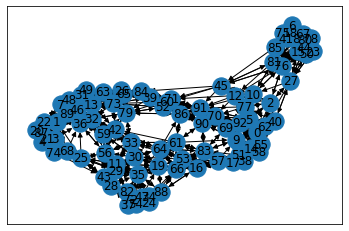

In [12]:
# networkx.draw(graph, with_labels=True, font_weight='bold')

nx.draw_networkx(g.to_networkx())
plt.show()

# from networkx.drawing.nx_agraph import graphviz_layout
# pos = graphviz_layout(graph)
# plt.axis('off')
# nx.draw_networkx_nodes(graph,pos,node_color='g',alpha = 0.8)  # draws nodes
# nx.draw_networkx_edges(graph,pos,edge_color='b',alpha = 0.6)  # draws edges
# nx.draw_networkx_edge_labels(graph,pos,edge_labels = nx.get_edge_attributes(graph,'weight')) # edge lables
# nx.draw_networkx_labels(graph,pos) # node lables

In [27]:
# find a dominating set of vertices which can be used for learning the rest of the vertices

from networkx.algorithms.dominating import dominating_set
g_nx = g.to_networkx()

# # to create our dataset, mimic missing measurements by finding some independent set of graph
# we will attempt to learn it!
remove = dominating_set(g_nx)

keep = np.asarray(list(set(np.arange(len(g_nx))) - remove), dtype=np.int64)
remove = np.asarray(list(remove), dtype=np.int64)
len(keep) + len(remove)
print(f'Using only {len(remove)} nodes to learn about the rest of {len(keep)} nodes')

Using only 14 nodes to learn about the rest of 79 nodes


#### The Model used - Weighed Graph Convolutions
We will use a 3 layer Graph Convolution Network.
Instead of summing the neighbors features to each node, the aggregation function will take a weighted mean of each neighbors' features. 
A softmax function will be used to create probablity-like weights from the distance of each node. We will take a complement of this (1 minus the result) in order for closer nodes to affect the features more than the further ones.


In [14]:
class WeighedGraphConv(nn.Module):

    def __init__(self,
                 in_feats,
                 out_feats,
                 num_neighbors, 
                 weight=True,
                 bias=True):
        super(WeighedGraphConv, self).__init__()

        self._in_feats = in_feats
        self._out_feats = out_feats
        self.num_neighbors = num_neighbors

        self.weight = nn.Parameter(torch.Tensor(in_feats, out_feats))
        torch.nn.init.xavier_uniform_(self.weight)

        self.bias = nn.Parameter(torch.Tensor(out_feats))          


    # graph is the complete input graph (data), feat are the learned nodes (shared between all graphs)
    # edges are the learned edges (shared between all graphs)
    def forward(self, graph, feat, edges):
        graph = graph.local_var()
        # normalize input features
        degs = graph.out_degrees().to(feat.device).float().clamp(min=1)
        norm = torch.pow(degs, -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)
        feat = feat * norm

        weight = self.weight

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, weight)
        graph.srcdata['h'] = feat

        graph.edata['ee'] = edges

        graph.update_all(fn.u_mul_e('h', 'ee', 'm'), fn.sum('m', 'h'))

        # graph.update_all(fn.copy_src(src='h', out='m'), fn.mean(msg='m', out='h'))
        rst = graph.dstdata['h']

        if self.bias is not None:
            rst = rst + self.bias

        return rst



TanH functions are used in between the layers. 
The nodes have 5-dimension features which are initialized with a normal distribution.

In [15]:
from dgl.nn import GATConv

class Net(nn.Module):
    # def __init__(self, in_feats, hidden_size, num_neighbors):
    #     super(Net, self).__init__()
    #     self.conv1 = WeighedGraphConv(5, 5, num_neighbors)
    #     self.conv2 = WeighedGraphConv(5, 5, num_neighbors)
    #     self.conv3 = WeighedGraphConv(5, 1, num_neighbors)


    # def forward(self, g, feats_, edges_):
    #     h = self.conv1(g, feats_, edges_)
    #     h = torch.tanh(h)
    #     # h = torch.nn.functional.leaky_relu(h, 0.1)
    #     h = self.conv2(g, h, edges_)
    #     h = torch.tanh(h)
    #     # h = torch.nn.functional.leaky_relu(h, 0.1)
    #     h = self.conv3(g, h, edges_)
    #     return h

    def __init__(self, in_feats, hidden_size, num_neighbors):
        super(Net, self).__init__()
        self.conv1 = GATConv(5, 5, 1, residual=False)
        self.conv2 = GATConv(5, 5, 1, residual=False)
        self.conv3 = GATConv(5, 1, 1, residual=False)


    def forward(self, g, feats_, edges_):
        h = self.conv1(g, feats_)
        # h = torch.tanh(h).squeeze()
        # h = torch.nn.functional.leaky_relu(h, 0.1)

        h = self.conv2(g, h)
        # h = torch.tanh(h)
        # h = torch.nn.functional.leaky_relu(h, 0.1)
        h = self.conv3(g, h)
        return h

net = Net(5, 5, num_neighbors)  # num_of_classes = temp
print(net)

embed = nn.Embedding(len(g), 3)  # |g| nodes with embedding dim equal to 2
edges_embed = nn.Embedding(g.edata['distance'].shape[0], 1)  # 


Net(
  (conv1): GATConv(
    (fc): Linear(in_features=5, out_features=5, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (conv2): GATConv(
    (fc): Linear(in_features=5, out_features=5, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (conv3): GATConv(
    (fc): Linear(in_features=5, out_features=1, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
)


#### Training and Validation
We will only use the dominating set of nodes for supervision. The rest of the node features will be learned.
We train for 300 epochs.
Adam optimizer and MSE loss were used.


In [16]:
labeled_nodes = torch.from_numpy(remove) # only a small part of the nodes are used for supervision
unlabeled_nodes = torch.from_numpy(keep)

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters(), edges_embed.parameters()), lr=0.1)

scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 20
losses = []
accuracies = []


# learn_e, unlearn_e = edges[:, 0], edges[:, 1]
# efeat = unlearn_e  # graph.edges[:].data['distance'].unsqueeze(-1)
# efeat = F.softmax(efeat.view(self.num_neighbors, -1), dim=0)
# efeat = 1 - efeat
# efeat = efeat.flatten().repeat(2).view(-1, 2) #.unsqueeze(-1)
# graph.edata['ee'] = learn_e * unlearn_e #torch.cat([efeat, edges], 1)


for epoch in range(num_epochs):
    # Decay LearQning Rate
    scheduler.step()


    running_loss = 0.0
    running_temp_err = 0.0

    iter = 0
    for date, g in graph_dict.items():
        iter += 1

        # build features according to current graph
        # the node features are partially initialized with input data, and partially learned (shared between graphs)
        temp_ = g.ndata['temp']
        height_ = g.ndata['height']
        
        # normalize features
        temp_norm = torch.norm(temp_, p=2)
        # height_ = height_.div(torch.norm(height_, p=2))
        # temp_ = temp_.div(temp_norm)

        labels = torch.stack([temp_, height_], dim=1).detach()  # no grads here...
        labels[torch.from_numpy(keep), 0] = -300  # delete temp data 
        features = torch.cat([embed.weight, labels], 1)
        gt = torch.tensor(g.ndata['temp'])

        # prepare distances as probabilities
        edges_distance = g.edata['distance'].unsqueeze(-1).detach()  # no grads here...
        edges_distance = F.softmax(edges_distance.view(num_neighbors, -1), dim=0)
        edges_distance = 1 - edges_distance
        edges_distance = edges_distance.flatten()
        edges_dist_vec = torch.tensor(edges_distance, dtype=torch.float).detach()

        edges =  edges_dist_vec # *edges_embed.weight.squeeze()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # Set model to training mode
            else:
                net.eval()   # Set model to evaluate mode

            # print(features.shape)
            logits = net(g, features, edges).squeeze()

            # scale results back 
            # logits = logits.mul(temp _norm)

            # print(edges.mean())  # just to make sure they are changed...
            # print("Mean = ")
            # print(embed.weight.mean())

            if phase == 'train':
                # we only compute loss for labeled nodes
                loss = F.smooth_l1_loss(logits[labeled_nodes], gt[labeled_nodes])
            
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            else:  # eval phase (on training data, don't take grads)
                with torch.set_grad_enabled(False):
                    # validation accuracy - 
                    mean_err = torch.mean(torch.abs(logits[unlabeled_nodes] - gt[unlabeled_nodes] ))
                    running_temp_err += mean_err.data


    running_loss /= iter
    print('Epoch %d | Loss: %.4f' % (epoch, running_loss))
    losses.append(running_loss)

    running_temp_err /= iter
    print('Epoch %d | Mean Temp Error: %.4f' % (epoch, running_temp_err))
    accuracies.append(running_temp_err)



Epoch 0 | Loss: 24.3256
Epoch 0 | Mean Temp Error: 22.4686
Epoch 1 | Loss: 6.5276
Epoch 1 | Mean Temp Error: 6.7341
Epoch 2 | Loss: 4.7817
Epoch 2 | Mean Temp Error: 5.2876
Epoch 3 | Loss: 4.1948
Epoch 3 | Mean Temp Error: 4.7865
Epoch 4 | Loss: 4.1174
Epoch 4 | Mean Temp Error: 4.7060
Epoch 5 | Loss: 3.8072
Epoch 5 | Mean Temp Error: 4.4145
Epoch 6 | Loss: 4.3300
Epoch 6 | Mean Temp Error: 4.7982
Epoch 7 | Loss: 3.6746
Epoch 7 | Mean Temp Error: 4.1771
Epoch 8 | Loss: 4.4208
Epoch 8 | Mean Temp Error: 4.7688
Epoch 9 | Loss: 3.8573
Epoch 9 | Mean Temp Error: 4.1881
Epoch 10 | Loss: 3.4625
Epoch 10 | Mean Temp Error: 3.9121
Epoch 11 | Loss: 3.3961
Epoch 11 | Mean Temp Error: 3.8694
Epoch 12 | Loss: 3.5048
Epoch 12 | Mean Temp Error: 3.9643
Epoch 13 | Loss: 3.8431
Epoch 13 | Mean Temp Error: 4.2244
Epoch 14 | Loss: 3.3949
Epoch 14 | Mean Temp Error: 3.8473
Epoch 15 | Loss: 3.2418
Epoch 15 | Mean Temp Error: 3.7370
Epoch 16 | Loss: 3.2388
Epoch 16 | Mean Temp Error: 3.7328
Epoch 17 | Loss

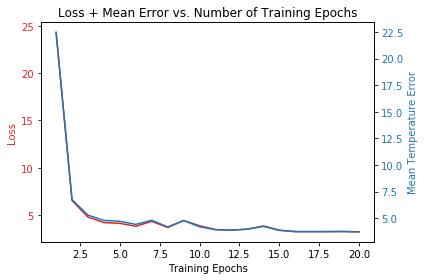

In [17]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1,num_epochs+1),losses,label="Loss", color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.title("Loss + Mean Error vs. Number of Training Epochs")
plt.xlabel("Training Epochs")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("Mean Temperature Error", color=color)  # we already handled the x-label with ax1
ax2.plot(range(1,num_epochs+1),accuracies,label="Mean Temp Error", color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [18]:
# Comparison to Linear Regression / Average of nodes?  TODO

In [21]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x, y)
Y_pred = linear_regressor.predict(X)  # make predictions

In [22]:
# x1 = np.asarray([df['elev_meters'].values], dtype=np.float32)
# x2 = np.asarray([df['AverageTemperature'].values], dtype=np.float32)

# x = np.concatenate((x1, x2), axis=0)
# x[:, remove]